In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [10]:
data = np.loadtxt('/Users/yao/Documents/Data/AMRVAC/test3/test_0005.blk',
           skiprows=2,usecols=[0,1,2,7,8,9])

In [11]:
data

array([[-2.38500e+01, -5.85000e+00,  3.28490e+04,  8.35430e-03,
         4.37490e-04, -5.55819e-06],
       [-2.35500e+01, -5.85000e+00,  3.30067e+04,  8.37273e-03,
         5.38384e-04, -1.37162e-05],
       [-2.32500e+01, -5.85000e+00,  3.30342e+04,  8.39800e-03,
         5.30926e-04, -2.54516e-05],
       ...,
       [ 0.00000e+00,  0.00000e+00,  8.10514e+03,  9.00407e-03,
         4.74332e-06, -5.61606e-06],
       [ 0.00000e+00,  0.00000e+00,  8.10231e+03,  9.00350e-03,
         1.86784e-06, -3.83468e-06],
       [ 0.00000e+00,  0.00000e+00,  8.10093e+03,  9.00309e-03,
        -2.98824e-07, -1.79947e-07]], shape=(274800, 6))

In [12]:
x, y, rho, bx, by, bz = data.T

In [13]:
# this is the function to reshape the data into a 2D grid
# due to the AMR, the data needs to be filled with NaN to make a regular grid
# which is not a good idea, but it is the only working method for now

def grid_data(x, y, data, Nx, Ny):
    xi = np.searchsorted(np.unique(x), x)
    yj = np.searchsorted(np.unique(y), y)
    flat_idx = xi * Ny + yj
    order = np.argsort(flat_idx)
    flat_idx = flat_idx[order]
    uniq_flat, start_idx, counts = np.unique(flat_idx, return_index=True, return_counts=True)
    data_sorted = data[order]
    data_sum = np.add.reduceat(data_sorted, start_idx)
    data_mean = data_sum / counts
    data_grid = np.full((Nx, Ny), np.nan)
    ii = uniq_flat // Ny
    jj = uniq_flat % Ny
    data_grid[ii, jj] = data_mean
    return data_grid

In [14]:
# we get the grid size from the unique x and y values, and then reshape the data accordingly
# and it is the XXX_grid 2D arrays that we have to use

xu = np.unique(x)
yu = np.unique(y)
Nx, Ny = xu.size, yu.size
print(Nx, Ny)
# Nx, Ny = 481, 81  # override for the test3 data

x_grid    = grid_data(x, y, x,   Nx, Ny)
y_grid    = grid_data(x, y, y,   Nx, Ny)
rho_grid  = grid_data(x, y, rho, Nx, Ny)
bx_grid   = grid_data(x, y, bx,  Nx, Ny)
by_grid   = grid_data(x, y, by,  Nx, Ny)
bz_grid   = grid_data(x, y, bz,  Nx, Ny)

1001 151


In [15]:
# prepare for plotting

xmin = np.min(x)
xmax = np.max(x)
ymin = np.min(y)
ymax = np.max(y)

print(xmin, xmax, ymin, ymax)

-23.85 47.85 -5.98125 0.0


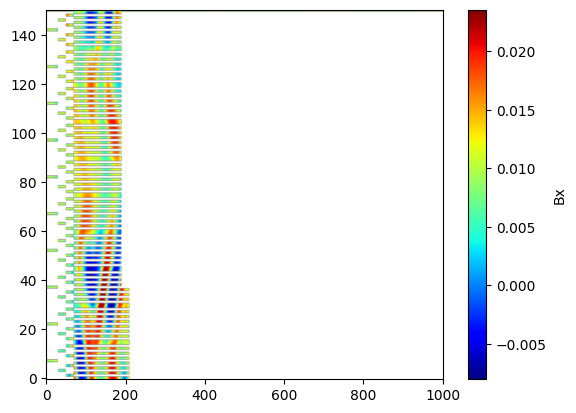

In [16]:
# have a quick visual check
# note the NaN values on the boundary of AMR blocks
# we will have to mask them out when doing FFT of the data (of the magnetic fields)
# for now, we just roughly take a range of [-10, 30] along x, which we see clearly that there is no NaN

plt.imshow(bx_grid.T, 
           origin='lower', 
        #    extent=(xmin, xmax, ymin, ymax), 
           cmap='jet',
           aspect='auto')
plt.colorbar(label='Bx')

In [17]:
nx, ny = 480, 80

X  = x.reshape(nx, ny, order='C')
Y  = y.reshape(nx, ny, order='C')
R  = rho.reshape(nx, ny, order='C')
BX = bx.reshape(nx, ny, order='C')
BY = by.reshape(nx, ny, order='C')
BZ = bz.reshape(nx, ny, order='C')

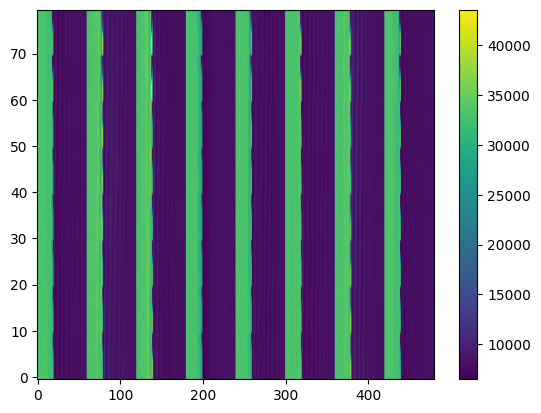

In [18]:
plt.imshow(R.T, origin='lower', aspect='auto')
plt.colorbar()

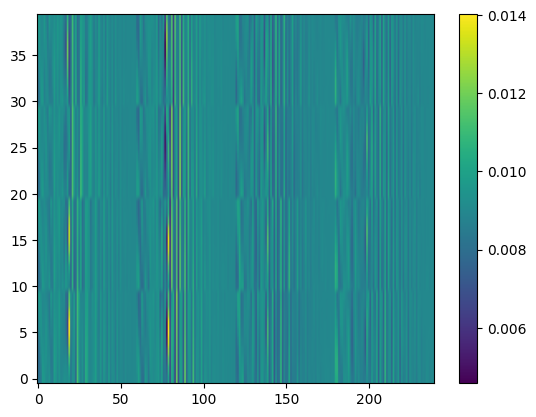

In [68]:
plt.imshow(BX.T, origin='lower', aspect='auto')
plt.colorbar()

In [38]:
# X should be nearly constant down rows (axis 0) and increase across columns (axis 1)
print("X across first row monotonic:", np.all(np.diff(X[0,:]) >= -1e-12))
print("Y down first column monotonic:", np.all(np.diff(Y[:,0]) >= -1e-12))
print("Shapes:", X.shape, Y.shape, R.shape, BX.shape, BY.shape, BZ.shape)

X across first row monotonic: False
Y down first column monotonic: False
Shapes: (240, 40) (240, 40) (240, 40) (240, 40) (240, 40) (240, 40)


In [40]:
import numpy as np

nx, ny = 240, 40

# 1) Sort by x then by y
idx_xy = np.lexsort((y, x))   # primary key: x, secondary: y
x_xy  = x[idx_xy]
y_xy  = y[idx_xy]
rho_xy = rho[idx_xy]
bx_xy  = bx[idx_xy]
by_xy  = by[idx_xy]
bz_xy  = bz[idx_xy]

# Option 1: make rows = unique x, columns = unique y (check shapes after)
X1 = x_xy.reshape(nx, ny)  # x constant down rows? then try transpose below
Y1 = y_xy.reshape(nx, ny)
R1 = rho_xy.reshape(nx, ny)
BX1 = bx_xy.reshape(nx, ny); BY1 = by_xy.reshape(nx, ny); BZ1 = bz_xy.reshape(nx, ny)

print("Option 1 monotonic checks:",
      np.all(np.diff(X1[0,:]) >= -1e-12),  # X across row
      np.all(np.diff(Y1[:,0]) >= -1e-12))  # Y down col

# Option 2: swap axes if needed
X1t, Y1t = X1.T, Y1.T
R1t, BX1t, BY1t, BZ1t = R1.T, BX1.T, BY1.T, BZ1.T
print("Option 1T monotonic checks:",
      np.all(np.diff(X1t[0,:]) >= -1e-12),
      np.all(np.diff(Y1t[:,0]) >= -1e-12))

# 2) Also try sorting by y then x (some files list y fastest)
idx_yx = np.lexsort((x, y))   # primary: y, secondary: x
x_yx  = x[idx_yx]
y_yx  = y[idx_yx]
rho_yx = rho[idx_yx]
bx_yx  = bx[idx_yx]
by_yx  = by[idx_yx]
bz_yx  = bz[idx_yx]

X2 = x_yx.reshape(nx, ny)
Y2 = y_yx.reshape(nx, ny)
R2 = rho_yx.reshape(nx, ny)
BX2 = bx_yx.reshape(nx, ny); BY2 = by_yx.reshape(nx, ny); BZ2 = bz_yx.reshape(nx, ny)

print("Option 2 monotonic checks:",
      np.all(np.diff(X2[0,:]) >= -1e-12),
      np.all(np.diff(Y2[:,0]) >= -1e-12))

X2t, Y2t = X2.T, Y2.T
R2t, BX2t, BY2t, BZ2t = R2.T, BX2.T, BY2.T, BZ2.T
print("Option 2T monotonic checks:",
      np.all(np.diff(X2t[0,:]) >= -1e-12),
      np.all(np.diff(Y2t[:,0]) >= -1e-12))

ValueError: cannot reshape array of size 384000 into shape (240,40)

/var/folders/2t/97rc3fl92tg15k2l_4sk5hsh0000gn/T/ipykernel_49208/2375761544.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X, Y, R, shading='auto')


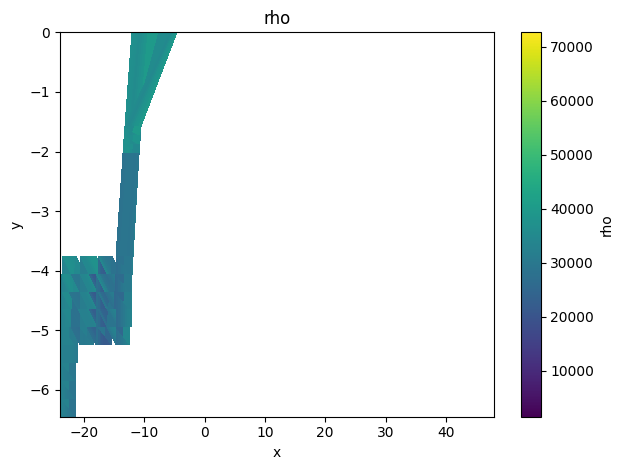

In [39]:
import matplotlib.pyplot as plt

plt.figure()
plt.pcolormesh(X, Y, R, shading='auto')
plt.xlabel('x')
plt.ylabel('y')
plt.title('rho')
plt.colorbar(label='rho')
plt.tight_layout()
plt.show()

In [33]:
import numpy as np

def _is_monotonic_inc(v):
    dv = np.diff(v, axis=-1)
    return np.all(dv >= -1e-12)  # tiny tolerance

def _score_xy(X, Y):
    # Heuristic: on a rectilinear grid
    # - X should be ~constant down rows (axis 0) and monotonic across columns (axis 1), OR vice-versa.
    # - Y should be the orthogonal pattern.
    # Tolerance for "constant" based on median spacing.
    def tol_from(a):
        d = np.diff(np.sort(a.ravel()))
        med = np.median(d[d > 0]) if np.any(d > 0) else 0.0
        return 5e-3 * med if med > 0 else 1e-12

    tx = tol_from(X)
    ty = tol_from(Y)

    row_std_X = np.std(X, axis=1)
    col_std_X = np.std(X, axis=0)
    row_std_Y = np.std(Y, axis=1)
    col_std_Y = np.std(Y, axis=0)

    # Pattern A: X constant along rows, monotonic across cols; Y constant along cols, monotonic down rows
    patA = (
        np.mean(row_std_X < tx) +
        _is_monotonic_inc(X[0, :]) +
        np.mean(col_std_Y < ty) +
        _is_monotonic_inc(Y[:, 0])
    )

    # Pattern B: X constant along cols, monotonic down rows; Y constant along rows, monotonic across cols
    patB = (
        np.mean(col_std_X < tx) +
        _is_monotonic_inc(X[:, 0]) +
        np.mean(row_std_Y < ty) +
        _is_monotonic_inc(Y[0, :])
    )

    return max(patA, patB)

def guess_grid(x, y, nx, ny):
    """
    x, y: 1D arrays (length nx*ny)
    Returns: X2D, Y2D, info dict
    """
    candidates = []
    # Four plausible ways: (shape, order)
    shapes = [("C", (nx, ny), 'C'),
              ("F", (nx, ny), 'F'),
              ("C_swap", (ny, nx), 'C'),
              ("F_swap", (ny, nx), 'F')]

    for name, shape, order in shapes:
        Xc = x.reshape(shape, order=order)
        Yc = y.reshape(shape, order=order)
        # Also consider the transposed variant because users often expect (nx, ny)
        for tflag in [False, True]:
            Xt = Xc.T if tflag else Xc
            Yt = Yc.T if tflag else Yc
            s = _score_xy(Xt, Yt)
            candidates.append((s, name + ("_T" if tflag else ""), Xt, Yt))

    # Pick best scoring candidate
    best = max(candidates, key=lambda z: z[0])
    score, label, Xbest, Ybest = best

    info = {
        "label": label,     # e.g., "F_swap_T"
        "score": float(score),
        "shape": Xbest.shape
    }
    return Xbest, Ybest, info

# ---- Example usage ----
nx, ny = 240, 40
# x, y are your 1D arrays of length 9600
X2D, Y2D, info = guess_grid(x, y, nx, ny)
print("Chosen arrangement:", info)
# Then reshape the rest the same way:
def apply_same(arr, info, nx, ny):
    label = info["label"]
    # Reconstruct the steps from the label
    if "swap" in label:
        shape_main = (ny, nx)
    else:
        shape_main = (nx, ny)
    order = 'F' if label.startswith("F") else 'C'
    A = arr.reshape(shape_main, order=order)
    if label.endswith("_T"):
        A = A.T
    return A

RHO2D = apply_same(rho, info, nx, ny)
BX2D  = apply_same(bx,  info, nx, ny)
BY2D  = apply_same(by,  info, nx, ny)
BZ2D  = apply_same(bz,  info, nx, ny)

Chosen arrangement: {'label': 'C', 'score': 1.9583333333333335, 'shape': (240, 40)}


In [ ]:
x, y, b1, b2, b3 = np.loadtxt('/Users/yao/Documents/Data/AMRVAC/test1/visit_b1_b2_b3_0010.xyz',
                        unpack=True,skiprows=2,usecols=[1,2,4,5,6])

# print(x.size)


332508


In [33]:
Nx=np.unique(x).size
Ny=np.unique(y).size

print(x.size)
print(Nx, Ny)

332508
1001 321


In [29]:
Nx=np.unique(x).size
Ny=np.unique(y).size

print(x.size)
print(Nx, Ny)

341220
1021 321


In [ ]:
5: 
332508
1001 321

In [17]:
mask = np.isnan(y)
print(mask)
print(np.any(mask))
print(np.sum(mask))
print(np.where(mask))

[False False False ... False False False]
False
0
(array([], dtype=int64),)


In [20]:
np.unique(x).size

1001

In [21]:
xmin=np.min(x)
xmax=np.max(x)
ymin=np.min(y)
ymax=np.max(y)

In [22]:
xyz_combined=np.vstack((x, y, b1, b2, b3)).T


In [23]:
xyz_sorted=xyz_combined[np.lexsort((xyz_combined[:, 1], xyz_combined[:, 0]))]


In [24]:
unique_xyz=np.unique(xyz_sorted, axis=0)


In [25]:
x, y, b1, b2, b3 =unique_xyz.T


In [26]:
x=x.reshape(Nx,Ny)

ValueError: cannot reshape array of size 276404 into shape (1001,321)